# Analisis Exploratorio del dataset

## Clustering

In [1]:
!nvidia-smi

Thu Nov 30 13:45:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A30          Off  | 00000000:43:00.0 Off |                    0 |
| N/A   31C    P0    28W / 165W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A30          Off  | 00000000:C4:00.0 Off |                    0 |
| N/A   

In [5]:
# get all sentences from csv files
import os
import pandas as pd

# Specify the directory containing CSV files
csv_directory = './datasets/datasets_csv'

# Initialize an empty list to store sentences
all_sentences = []

# Iterate through CSV files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        #print(filename)
        # Construct the full file path
        filepath = os.path.join(csv_directory, filename)
        
        # Read CSV file using pandas
        df = pd.read_csv(filepath)
        
        # Extract the 'text' column and append to the list
        all_sentences.extend(df['text'].tolist())

# Print the array of sentences
print(len(all_sentences))


719


In [9]:
all_sentences[0][:10]

'Los enanos'

In [10]:
!pip install sentence-transformers


  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Obtaining dependency information for transformers<5.0.0,>=4.6.0 from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
  Obtaining dependency information for torch>=1.6.0 from https://files.pythonhosted.org/packages/65/1f/de6bc1b246531db81d9a6afc491356b17d70e6c898e16f564970849f69b6/torch-2.1.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torch-2.1.1-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/36/3b/a1d0a681ec3abb1bb8ff92c303ed73c0437050d9ac2b210273dc26f3fd8f/torchvision-0.16.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.16.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for

In [11]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

sentences = all_sentences

# Encode sentences
sentence_embeddings = model.encode(sentences)


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Para hacer clustering tenemos que saber en cuántos clusters intentamos dividir. Primero con el método del elbow:

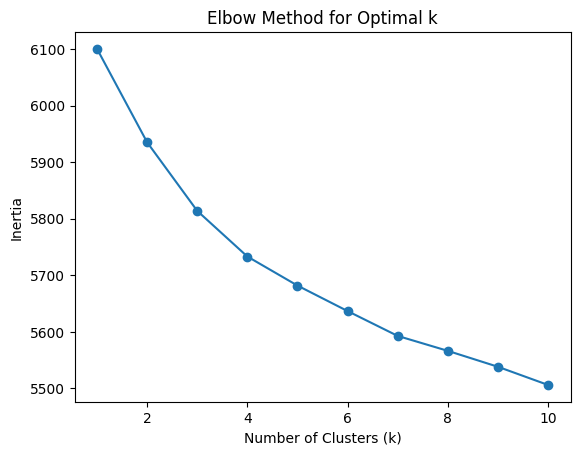

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming sentence_embeddings is your data
inertias = []
k_values = range(1, 11)  # Adjust the range based on your data

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
    kmeans.fit(sentence_embeddings)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


Resultado: No veo un codo distinguible... podría ser el 3 o el 4 pero es bastante smooth. No es un codito visible. Probemos otro método, el de la silueta:

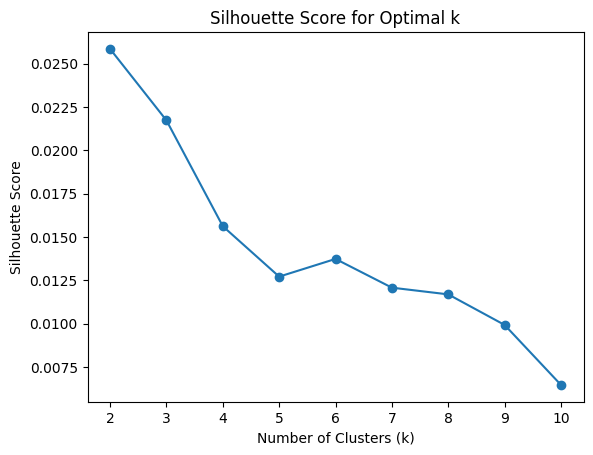

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming sentence_embeddings is your data
silhouette_scores = []
k_values = range(2, 11)  # Adjust the range based on your data

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
    cluster_labels = kmeans.fit_predict(sentence_embeddings)

    if len(set(cluster_labels)) > 1:  # Ensure there are at least two clusters
        silhouette_scores.append(silhouette_score(sentence_embeddings, cluster_labels))
    else:
        silhouette_scores.append(None)  # Set to None if only one cluster

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


The silhouette score is max at k=2. Pero veamos que no se despega realmente del 0... el rango de valores de la métrica de silueta es muy chica. Desestimo entonces kmeans para clustering. Pruebo con hierarchical clustering.

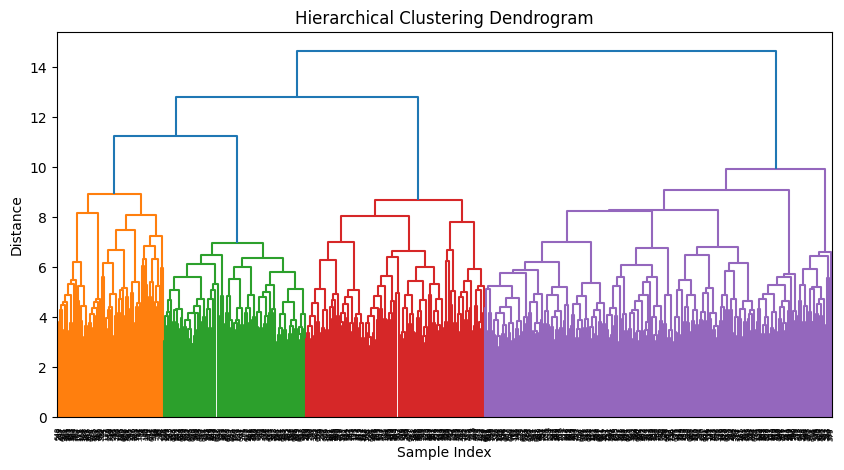

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate sample data
np.random.seed(42)
data = np.random.rand(10, 2)  # Replace this with your actual data

# Perform hierarchical clustering
linked = linkage(sentence_embeddings, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [61]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram to form k clusters
k = 4  # Replace with your desired number of clusters
clusters = fcluster(linked, k, criterion='maxclust')

# Print the cluster assignments
print("Cluster Assignments:", clusters)


Cluster Assignments: [2 3 1 3 1 2 4 2 4 2 3 3 3 3 4 4 2 4 4 1 1 4 2 4 1 4 1 2 1 1 1 2 1 1 1 3 1
 2 4 4 4 3 4 1 4 4 3 2 2 2 3 3 1 4 2 2 1 2 2 4 1 3 1 2 1 2 1 1 2 3 1 1 3 1
 1 1 2 3 4 1 3 1 2 2 1 4 1 1 4 4 1 1 4 1 2 1 1 1 1 1 3 1 1 1 4 1 4 1 2 1 1
 3 1 1 3 2 4 4 4 4 1 2 1 2 1 1 1 1 3 1 3 1 1 1 2 1 2 1 1 1 1 2 1 1 2 2 4 1
 1 1 1 3 1 4 3 1 3 1 3 3 4 3 3 2 2 2 2 1 2 1 1 4 1 1 4 2 3 1 3 4 2 1 1 3 1
 3 3 4 2 4 1 1 4 2 2 4 3 1 2 4 3 3 4 1 4 2 1 1 3 2 1 3 1 1 2 4 2 2 1 2 1 2
 1 2 3 1 1 2 2 1 1 1 4 2 1 3 1 1 1 3 1 1 2 3 1 2 1 4 4 1 1 2 1 1 1 1 1 1 3
 1 2 2 1 2 2 1 3 1 1 2 2 1 2 1 2 2 2 1 3 1 1 4 1 1 1 3 4 4 3 2 1 1 1 3 3 3
 3 2 2 2 4 3 2 2 2 2 3 2 2 1 4 1 4 2 2 2 1 1 1 1 3 1 2 1 2 2 1 3 1 1 3 1 4
 1 1 2 1 1 2 4 2 1 1 2 2 1 2 1 1 1 2 3 3 2 3 1 4 1 1 2 1 1 3 1 1 1 1 2 1 1
 1 1 1 2 3 1 1 3 2 1 1 1 1 4 1 3 4 2 1 1 1 2 4 1 2 3 2 1 1 1 2 4 1 2 3 3 2
 1 2 3 4 1 1 1 2 1 1 1 2 2 2 1 3 3 3 1 3 1 1 2 1 1 1 1 1 3 3 4 1 4 4 1 3 2
 4 1 1 2 3 2 2 2 4 1 2 2 2 3 3 3 2 3 2 1 1 2 1 1 2 2 2 1 3 1 1 3 2 2 1 3 1
 1 1

719


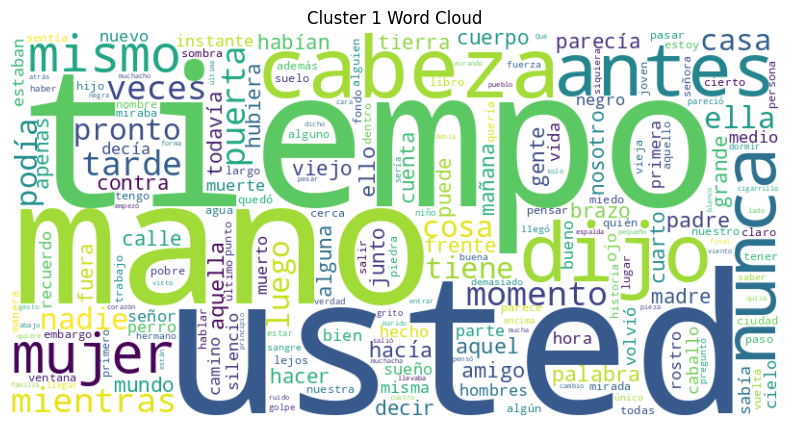

719


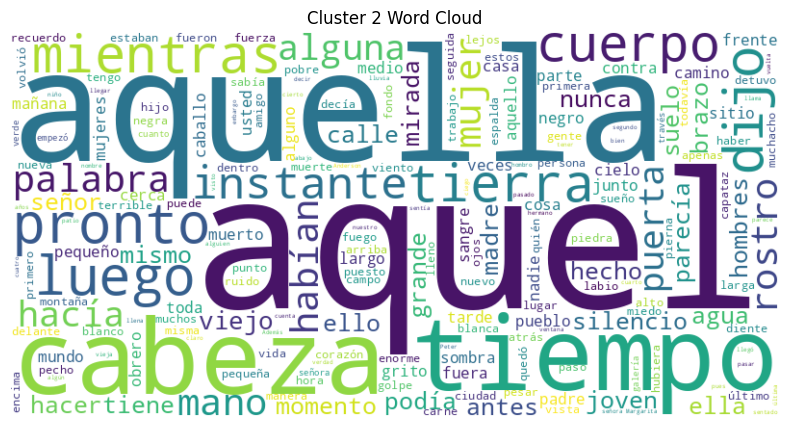

719


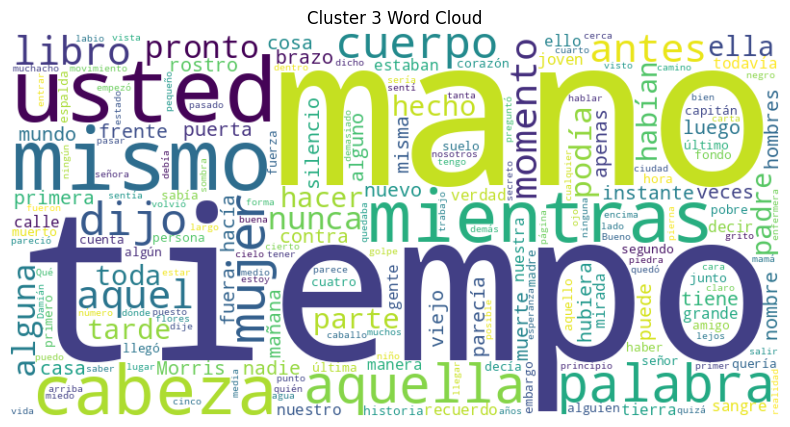

719


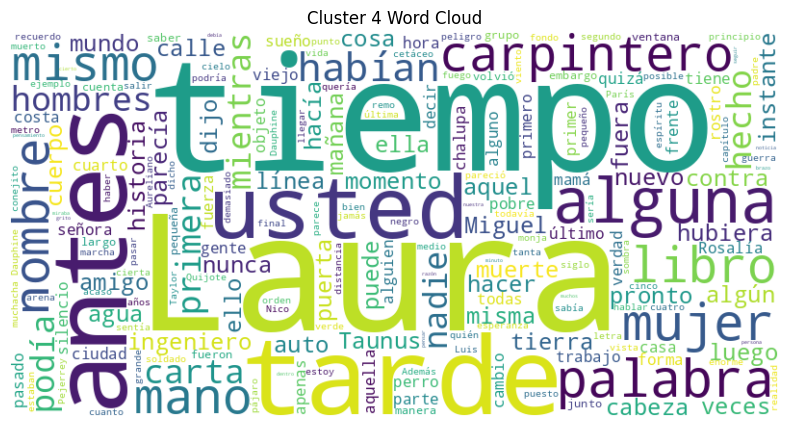

In [62]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
import numpy as np

# Assuming you already have the hierarchical clustering results in the 'clusters' variable

# Add custom stopwords to the default set
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en", "que", "se", "su", "lo", "le", "FIN", "fin","estaba","habia","había", "después","noche","hombre",
    "tenía","ahora","siempre","también","tambien"
    # Add more words as needed
])

def custom_stopwords_rule(word):
    return len(word) <= 4

stopwords = set(STOPWORDS).union(custom_stopwords)

# Assuming you have hierarchical clustering results in the 'clusters' variable
# Perform hierarchical clustering (if not performed earlier)
# linked = linkage(sentence_embeddings, 'ward')
# clusters = fcluster(linked, k, criterion='maxclust')

# Generate word cloud for each cluster
for cluster_id in np.unique(clusters):
    cluster_mask = (clusters == cluster_id)
    print(len(clusters))
    cluster_sentences = [all_sentences[i] for i, is_in_cluster in enumerate(cluster_mask) if is_in_cluster]
    cluster_text = ' '.join(cluster_sentences)
   # Apply custom filtering rule
    filtered_words = [word for word in ' '.join(cluster_sentences).split() if not custom_stopwords_rule(word)]

    # Join the filtered words back into a text
    filtered_text = ' '.join(filtered_words)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(filtered_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_id} Word Cloud')
    plt.axis('off')
    plt.show()


In [66]:
import random

# Assuming you have hierarchical clustering results in the 'clusters' variable
# Assuming you have sentences as a list of strings

# Set the number of random examples to display per cluster
n_random_examples = 5

# Set the number of characters to display for each example
m_chars = 50

# Generate word cloud for each cluster
for cluster_id in np.unique(clusters):
    cluster_mask = (clusters == cluster_id)
    cluster_indices = np.where(cluster_mask)[0]

    # Convert NumPy array to Python list
    cluster_indices_list = list(cluster_indices)

    # Display n random examples from the cluster
    random_examples = random.sample(cluster_indices_list, min(n_random_examples, len(cluster_indices_list)))

    print(f"Cluster {cluster_id} Examples:")
    for example_index in random_examples:
        example_text = all_sentences[example_index][:m_chars]
        print(f"  Example {example_index}: {example_text}")

    print("\n" + "=" * 30 + "\n")


Cluster 1 Examples:
  Example 366: En el año 32 Yamandú Rodríguez y yo hicimos una gi
  Example 541: En el restaurante de los cronopios pasan estas cos
  Example 207: La mujer no se atrevía a pensar. Cuando creía oír 
  Example 651: Era la última hormiga de la caravana, y no pudo se
  Example 467: La extracción de un caballo en la mina, acontecimi


Cluster 2 Examples:
  Example 82: Cuando alguien muere, sus recuerdos y experiencias
  Example 272: Mi labor consiste en limpiar cuidadosamente las lá
  Example 242: Cuando aquella vasta isla que los antiguos llamaba
  Example 359: Los dos viajeros bebían el último trago de vino, d
  Example 47: Porque día a día los orgullosos humanos que ahora 


Cluster 3 Examples:
  Example 646: Después de una larga experiencia, los agricultores
  Example 506: Cuando los últimos convidados se despidieron, la p
  Example 632: La proposición de la boa es tan irracional que sed
  Example 51: Que el doctor Z es ilustre, elocuente, conquistado
  Example 404: 

Sigue siendo difuso el entendimiento del dataset. Probemos con LDA:

In [69]:
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from pprint import pprint

# Tokenize the documents into words and remove stopwords
tokenized_documents = [
    [word for word in document.lower().split() if word not in STOPWORDS]
    for document in all_sentences
]

# Create a dictionary mapping of words to unique integer IDs
dictionary = corpora.Dictionary(tokenized_documents)


# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and associated words
pprint(lda_model.print_topics())

# Get the topic distribution for a specific document
doc = tokenized_documents[0]
bow = dictionary.doc2bow(doc)
print(lda_model.get_document_topics(bow))


[(0,
  '0.044*"la" + 0.036*"el" + 0.034*"y" + 0.027*"en" + 0.026*"que" + '
  '0.021*"los" + 0.017*"se" + 0.013*"las" + 0.013*"del" + 0.012*"su"'),
 (1,
  '0.006*"la" + 0.003*"y" + 0.002*"que" + 0.002*"en" + 0.002*"el" + '
  '0.002*"para" + 0.002*"su" + 0.002*"una" + 0.001*"del" + 0.001*"las"'),
 (2,
  '0.040*"la" + 0.038*"que" + 0.035*"y" + 0.030*"el" + 0.025*"en" + 0.015*"se" '
  '+ 0.014*"los" + 0.012*"una" + 0.011*"las" + 0.009*"por"'),
 (3,
  '0.001*"portugués." + 0.001*"-dijo" + 0.001*"portugués" + 0.000*"el" + '
  '0.000*"-preguntó" + 0.000*"c." + 0.000*"b." + 0.000*"segundo" + 0.000*"a." '
  '+ 0.000*"tercer"'),
 (4,
  '0.016*"el" + 0.016*"y" + 0.013*"la" + 0.012*"en" + 0.009*"que" + '
  '0.009*"las" + 0.009*"su" + 0.009*"del" + 0.008*"se" + 0.007*"los"')]
[(0, 0.51246417), (1, 0.0101324245), (2, 0.4571212), (3, 0.010098663), (4, 0.010183578)]


Con custom stopwords:

In [73]:
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from pprint import pprint

# Add your custom stopwords to the set
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en", "que", "se", "su", "lo", "le", "FIN", "fin","estaba","habia","había", "después",
    "tenía","ahora","siempre","también","tambien","era",
    "sus","mi","es","yo","ya","aquel","fue","ese","nos",
    "te" ,"vez" ,"qué" ,"ha"
    # Add more words as needed
])

# Update the STOPWORDS set with your custom stopwords
STOPWORDS |= custom_stopwords
# Tokenize the documents into words and remove stopwords
tokenized_documents = [
    [word for word in document.lower().split() if word not in STOPWORDS]
    for document in all_sentences
]

# Create a dictionary mapping of words to unique integer IDs
dictionary = corpora.Dictionary(tokenized_documents)


# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and associated words
pprint(lda_model.print_topics())

# Get the topic distribution for a specific document
doc = tokenized_documents[0]
bow = dictionary.doc2bow(doc)
print(lda_model.get_document_topics(bow))


[(0,
  '0.002*"ella" + 0.002*"hombre" + 0.002*"dos" + 0.002*"tu" + 0.002*"ser" + '
  '0.002*"esa" + 0.001*"día" + 0.001*"son" + 0.001*"este" + 0.001*"está"'),
 (1,
  '0.002*"dos" + 0.002*"esa" + 0.002*"él" + 0.002*"este" + 0.002*"uno" + '
  '0.002*"ojos" + 0.001*"aquella" + 0.001*"voz" + 0.001*"mientras" + '
  '0.001*"hay"'),
 (2,
  '0.003*"él" + 0.002*"ella" + 0.002*"dos" + 0.002*"esa" + 0.002*"mis" + '
  '0.002*"día" + 0.002*"ojos" + 0.002*"esta" + 0.002*"este" + 0.002*"uno"'),
 (3,
  '0.004*"ella" + 0.004*"él" + 0.003*"dos" + 0.003*"ojos" + 0.002*"dijo" + '
  '0.002*"esa" + 0.002*"casi" + 0.002*"hombre" + 0.002*"iba" + 0.002*"día"'),
 (4,
  '0.002*"esa" + 0.002*"dos" + 0.002*"mis" + 0.002*"él" + 0.001*"está" + '
  '0.001*"ser" + 0.001*"día" + 0.001*"esta" + 0.001*"ella" + 0.001*"mientras"')]
[(0, 0.014780972), (1, 0.0146489795), (2, 0.014846614), (3, 0.9382139), (4, 0.017509572)]


Sacando extremos:

In [68]:
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from pprint import pprint


# Tokenize the documents into words and remove stopwords
tokenized_documents = [
    [word for word in document.lower().split() if word not in STOPWORDS]
    for document in all_sentences
]

# Create a dictionary mapping of words to unique integer IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Filter out stopwords and extreme terms from the dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and associated words
pprint(lda_model.print_topics())

# Get the topic distribution for a specific document
doc = tokenized_documents[0]
bow = dictionary.doc2bow(doc)
print(lda_model.get_document_topics(bow))


[(0,
  '0.006*"aquel" + 0.004*"aquella" + 0.004*"hacia" + 0.003*"voz" + '
  '0.003*"mientras" + 0.003*"ojos" + 0.002*"mirada" + 0.002*"instante" + '
  '0.002*"sólo" + 0.002*"algunos"'),
 (1,
  '0.005*"mi" + 0.003*"ojos" + 0.003*"aquel" + 0.003*"hacia" + 0.003*"tenía" + '
  '0.003*"donde" + 0.003*"yo" + 0.003*"cabeza" + 0.003*"bajo" + 0.002*"día"'),
 (2,
  '0.005*"te" + 0.004*"él" + 0.004*"ella" + 0.004*"mi" + 0.004*"tenía" + '
  '0.004*"ojos" + 0.003*"agua" + 0.003*"yo" + 0.003*"hacia" + 0.003*"hombre"'),
 (3,
  '0.013*"mi" + 0.012*"yo" + 0.005*"ella" + 0.005*"nos" + 0.005*"él" + '
  '0.004*"qué" + 0.004*"esa" + 0.004*"mis" + 0.004*"ese" + 0.004*"tenía"'),
 (4,
  '0.005*"ha" + 0.004*"esa" + 0.004*"son" + 0.003*"todos" + 0.003*"este" + '
  '0.003*"ese" + 0.003*"cada" + 0.003*"hay" + 0.003*"hombre" + 0.002*"uno"')]
[(0, 0.017112933), (1, 0.017139833), (2, 0.017066179), (3, 0.52579945), (4, 0.42288157)]


Sacando extremos y custom stopwords:

In [74]:
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from pprint import pprint

# Add your custom stopwords to the set
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en", "que", "se", "su", "lo", "le", "FIN", "fin","estaba","habia","había", "después",
    "tenía","ahora","siempre","también","tambien","era",
    "sus","mi","es","yo","ya","aquel","fue","ese","nos",
    "te" ,"vez" ,"qué" ,"ha"
    # Add more words as needed
])

# Update the STOPWORDS set with your custom stopwords
STOPWORDS |= custom_stopwords
# Tokenize the documents into words and remove stopwords
tokenized_documents = [
    [word for word in document.lower().split() if word not in STOPWORDS]
    for document in all_sentences
]

# Create a dictionary mapping of words to unique integer IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Filter out stopwords and extreme terms from the dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and associated words
pprint(lda_model.print_topics())

# Get the topic distribution for a specific document
doc = tokenized_documents[0]
bow = dictionary.doc2bow(doc)
print(lda_model.get_document_topics(bow))


[(0,
  '0.003*"eva" + 0.003*"él" + 0.003*"día" + 0.003*"noche" + 0.003*"general" + '
  '0.003*"voz" + 0.002*"mano" + 0.002*"ojos" + 0.002*"hombre" + 0.002*"les"'),
 (1,
  '0.007*"ella" + 0.004*"él" + 0.003*"ojos" + 0.003*"mis" + 0.003*"está" + '
  '0.003*"hombre" + 0.003*"esa" + 0.003*"ser" + 0.003*"mujer" + 0.003*"usted"'),
 (2,
  '0.004*"hombre" + 0.004*"mis" + 0.003*"esa" + 0.003*"este" + 0.003*"día" + '
  '0.003*"esta" + 0.003*"son" + 0.002*"ser" + 0.002*"hay" + 0.002*"uno"'),
 (3,
  '0.006*"él" + 0.005*"esa" + 0.004*"ella" + 0.004*"casi" + 0.004*"iba" + '
  '0.004*"dijo" + 0.003*"algo" + 0.003*"antes" + 0.003*"noche" + 0.003*"bien"'),
 (4,
  '0.004*"aquella" + 0.003*"ojos" + 0.003*"voz" + 0.003*"mientras" + '
  '0.003*"él" + 0.002*"instante" + 0.002*"sólo" + 0.002*"que," + '
  '0.002*"cabeza" + 0.002*"habían"')]
[(0, 0.017055688), (1, 0.9316031), (2, 0.017145889), (3, 0.017240116), (4, 0.016955268)]


In [76]:
len(corpus)

719

In [81]:
# Explore topics for each document
for doc_index in range(10):
    doc = tokenized_documents[doc_index]
    bow = dictionary.doc2bow(doc)

    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow)
    pprint(lda_model.print_topics())

    # Print the document index and its associated topics
    print(f"Document {doc_index} Topics:")
    print(lda_model.get_document_topics(bow))

    print("=" * 30)

[(0,
  '0.003*"eva" + 0.003*"él" + 0.003*"día" + 0.003*"noche" + 0.003*"general" + '
  '0.003*"voz" + 0.002*"mano" + 0.002*"ojos" + 0.002*"hombre" + 0.002*"les"'),
 (1,
  '0.007*"ella" + 0.004*"él" + 0.003*"ojos" + 0.003*"mis" + 0.003*"está" + '
  '0.003*"hombre" + 0.003*"esa" + 0.003*"ser" + 0.003*"mujer" + 0.003*"usted"'),
 (2,
  '0.004*"hombre" + 0.004*"mis" + 0.003*"esa" + 0.003*"este" + 0.003*"día" + '
  '0.003*"esta" + 0.003*"son" + 0.002*"ser" + 0.002*"hay" + 0.002*"uno"'),
 (3,
  '0.006*"él" + 0.005*"esa" + 0.004*"ella" + 0.004*"casi" + 0.004*"iba" + '
  '0.004*"dijo" + 0.003*"algo" + 0.003*"antes" + 0.003*"noche" + 0.003*"bien"'),
 (4,
  '0.004*"aquella" + 0.003*"ojos" + 0.003*"voz" + 0.003*"mientras" + '
  '0.003*"él" + 0.002*"instante" + 0.002*"sólo" + 0.002*"que," + '
  '0.002*"cabeza" + 0.002*"habían"')]
Document 0 Topics:
[(0, 0.017055774), (1, 0.93158156), (2, 0.017146008), (3, 0.017261358), (4, 0.01695532)]
[(0,
  '0.003*"eva" + 0.003*"él" + 0.003*"día" + 0.003*"noche" 

In [75]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the topics
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Acá se puede ver cómo kmeans no separa nada:

/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


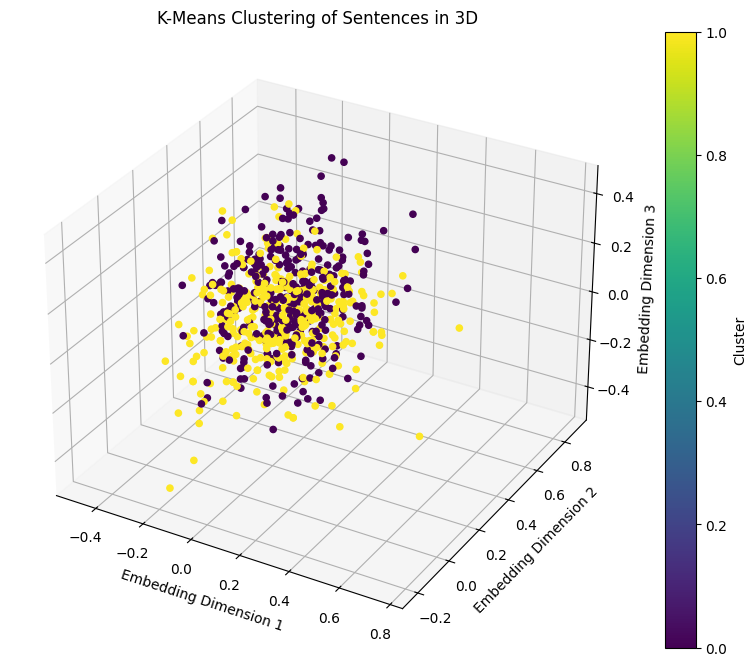

Cluster 1 Sentences:
- Con precaución, como a cualquier cosa pequeña. Pero sin miedo. Finalmente se descubrirá que ninguna fábula es dañina, excepto cuando alcanza a verse en ella alguna enseñanza. Esto es malo.   Si no fuera malo, el mundo se regiría por las fábulas de Esopo; pero en tal caso desaparecería todo lo que hace interesante el mundo, como los ricos, los prejuicios raciales, el color de la ropa interior y la guerra; y el mundo sería entonces muy aburrido, porque no habría heridos para las sillas de ruedas, ni pobres a quienes ayudar, ni negros para trabajar en los muelles, ni gente bonita para la revista Vogue. Así, lo mejor es acercarse a las fábulas buscando de qué reír. -Eso es. He ahí un libro de fábulas. Corre a comprarlo. No, mejor te lo regalo: verás, yo nunca me había reído tanto. FIN   La palabra mágica, 1983  
- Tirada en el campo estaba desde hacía tiempo una Flauta que ya nadie tocaba, hasta que un día un Burro que paseaba por ahí resopló fuerte sobre ella hacién

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Assuming sentence_embeddings is your data with 3 dimensions
num_clusters = 2  # Adjust based on your optimal k
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(sentence_embeddings)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the clusters in 3D
scatter = ax.scatter(
    sentence_embeddings[:, 0],
    sentence_embeddings[:, 1],
    sentence_embeddings[:, 2],
    c=clusters,
    cmap='viridis',
    alpha=1
)

# Add labels and title
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_zlabel('Embedding Dimension 3')
ax.set_title('K-Means Clustering of Sentences in 3D')

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster')

plt.show()

# Print the sentences in each cluster
for cluster_id in range(num_clusters):
    cluster_sentences = [sentences[i] for i, cluster_label in enumerate(clusters) if cluster_label == cluster_id][:3]
    print(f"Cluster {cluster_id + 1} Sentences:")
    for sentence in cluster_sentences:
        print("-", sentence)
    print()


/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


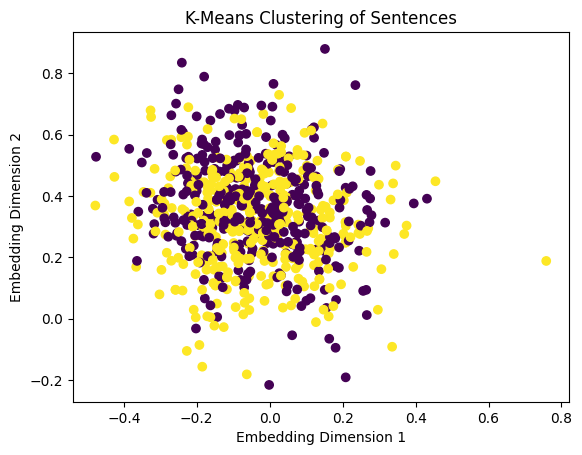

Cluster 1 Sentences:
- Con precaución, como a cualquier cosa pequeña. Pero sin miedo. Finalmente se descubrirá que ninguna fábula es dañina, excepto cuando alcanza a verse en ella alguna enseñanza. Esto es malo.   Si no fuera malo, el mundo se regiría por las fábulas de Esopo; pero en tal caso desaparecería todo lo que hace interesante el mundo, como los ricos, los prejuicios raciales, el color de la ropa interior y la guerra; y el mundo sería entonces muy aburrido, porque no habría heridos para las sillas de ruedas, ni pobres a quienes ayudar, ni negros para trabajar en los muelles, ni gente bonita para la revista Vogue. Así, lo mejor es acercarse a las fábulas buscando de qué reír. -Eso es. He ahí un libro de fábulas. Corre a comprarlo. No, mejor te lo regalo: verás, yo nunca me había reído tanto. FIN   La palabra mágica, 1983  
- Tirada en el campo estaba desde hacía tiempo una Flauta que ya nadie tocaba, hasta que un día un Burro que paseaba por ahí resopló fuerte sobre ella hacién

In [15]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
num_clusters = 2  # You can adjust the number of clusters based on your preference
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(sentence_embeddings)

# Plot the clusters
plt.scatter(sentence_embeddings[:, 0], sentence_embeddings[:, 1], c=clusters, cmap='viridis', alpha=1)
plt.title('K-Means Clustering of Sentences')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

# Print the sentences in each cluster
for cluster_id in range(num_clusters):
    cluster_sentences = [sentences[i] for i, cluster_label in enumerate(clusters) if cluster_label == cluster_id][:5]
    print(f"Cluster {cluster_id + 1} Sentences:")
    for sentence in cluster_sentences:
        print("-", sentence)
    print()

In [16]:
from sklearn.metrics.pairwise import cosine_distances

k = 2  # Replace with your optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Find exemplar for each cluster
for cluster_id in range(k):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_sentences = [sentences[i] for i, is_in_cluster in enumerate(cluster_mask) if is_in_cluster]

    # Find sentence closest to the cluster centroid
    cluster_center = sentence_embeddings[cluster_mask].mean(axis=0).reshape(1, -1)
    closest_sentence_idx = cosine_distances(cluster_center, sentence_embeddings[cluster_mask]).argmin()
    exemplar_sentence = cluster_sentences[closest_sentence_idx]

    print(f"Cluster {cluster_id + 1} Exemplar: {exemplar_sentence}")


/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1 Exemplar: Tantos años huyendo y esperando y ahora el enemigo estaba en mi casa. Desde la ventana lo vi subir penosamente por el áspero camino del cerro. Se ayudaba con un bastón, con un torpe bastón que en sus viejas manos no podía ser un arma sino un báculo. Me costó percibir lo que esperaba: el débil golpe contra la puerta. Miré, no sin nostalgia, mis manuscritos, el borrador a medio concluir y el tratado de Artemidoro sobre los sueños, libro un tanto anómalo ahí, ya que no sé griego. Otro día perdido, pensé. Tuve que forcejear con la llave. Temí que el hombre se desplomara, pero dio unos pasos inciertos, soltó el bastón, que no volví a ver, y cayó en mi cama, rendido. Mi ansiedad lo había imaginado muchas veces, pero solo entonces noté que se parecía, de un modo casi fraternal, al último retrato de Lincoln. Serían las cuatro de la tarde. Me incliné sobre él para que me oyera. -Uno cree que los años pasan para uno -le dije-, pero pasan también para los demás. Aquí nos encon

In [17]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


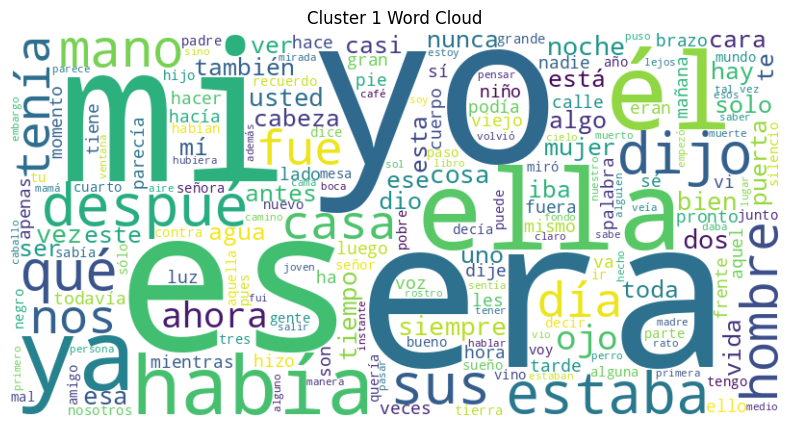

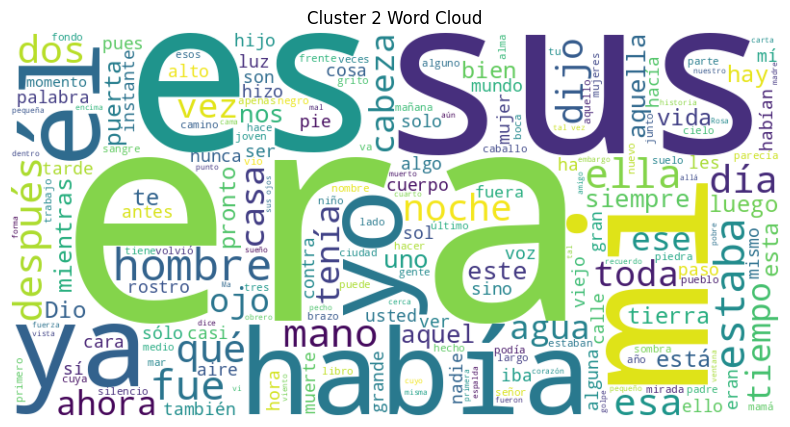

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# Add custom stopwords to the default set
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en","que","se","su","lo","le","FIN","fin"
    # Add more words as needed
])
def custom_stopwords_rule(word):
    return len(word) <= 3

stopwords = set(STOPWORDS).union(custom_stopwords)

k = 2  # Replace with your optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Generate word cloud for each cluster
for cluster_id in range(k):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_sentences = [sentences[i] for i, is_in_cluster in enumerate(cluster_mask) if is_in_cluster]
    cluster_text = ' '.join(cluster_sentences)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_id + 1} Word Cloud')
    plt.axis('off')
    plt.show()


/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


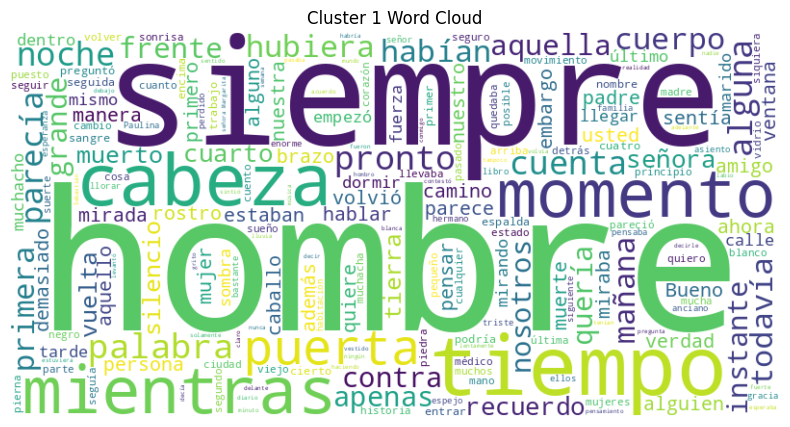

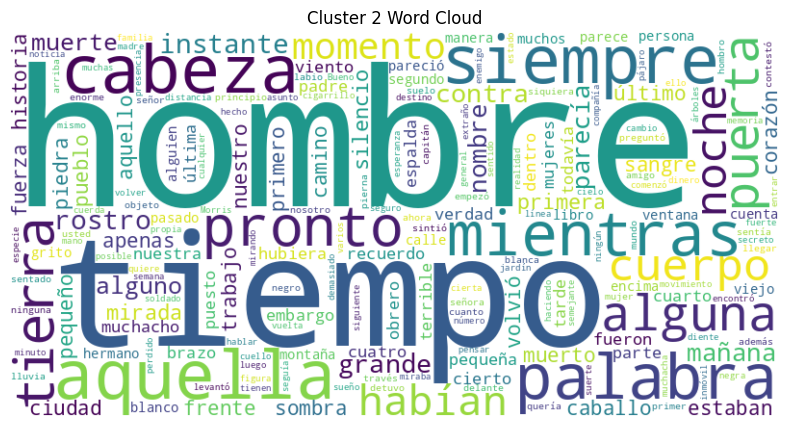

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def custom_stopwords_rule(word):
    return len(word) <= 5
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en","que","se","su","lo","le","FIN","fin","entonces","estaba","cuando","porque",
    "despué","después","también","tambien"
    # Add more words as needed
])
stopwords = set(STOPWORDS).union(custom_stopwords)

# Assuming you already have the custom_stopwords_spanish set from the previous example

# Your existing code for clustering and generating word clouds
k = 2  # Replace with your optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Generate word cloud for each cluster
for cluster_id in range(k):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_sentences = [sentences[i] for i, is_in_cluster in enumerate(cluster_mask) if is_in_cluster]
    
    # Apply custom filtering rule
    filtered_words = [word for word in ' '.join(cluster_sentences).split() if not custom_stopwords_rule(word)]

    # Join the filtered words back into a text
    filtered_text = ' '.join(filtered_words)

    # Generate word cloud with filtered text
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(filtered_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_id + 1} Word Cloud')
    plt.axis('off')
    plt.show()


/home/rgbellion/micromamba/envs/sardine/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


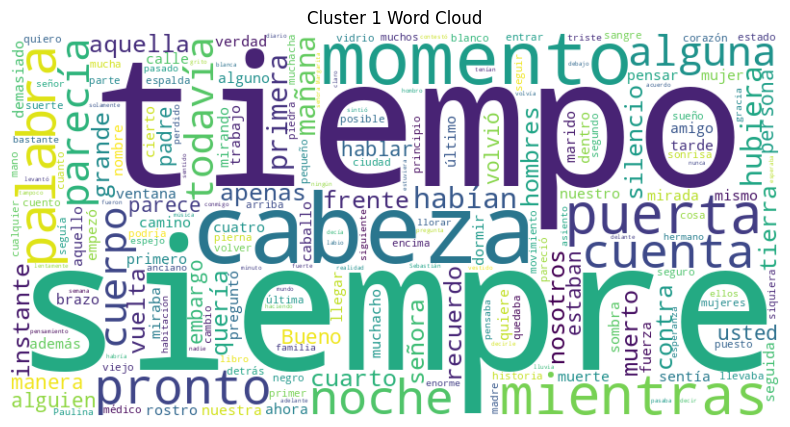

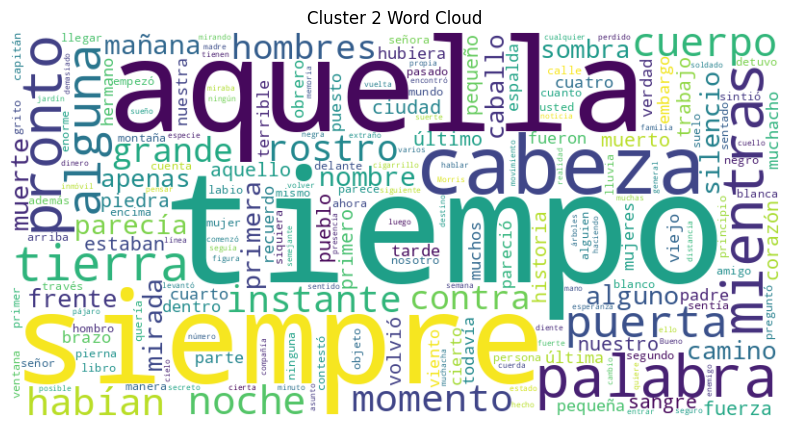

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def custom_stopwords_rule(word):
    return len(word) <= 5
custom_stopwords = set([
    "el", "la", "los", "las", "un", "una", "unos", "unas",
    "y", "o", "u", "e", "con", "sin", "por", "para",
    "al", "del", "a", "de", "en", "durante", "tras", "entre",
    "como", "hasta", "desde", "hacia", "ante", "bajo", "sobre",
    "si", "no", "ni", "pero", "porque", "aunque", "cuando",
    "esto", "eso", "aquí", "ahí", "allí", "entonces", "así",
    "muy", "más", "menos", "mejor", "peor", "tan", "tanto", "todo",
    "todos", "cada", "cual", "cuando", "donde", "quien", "cómo",
    "mucho", "poco", "nada", "otros", "otras", "otro", "otra",
    "y", "en","que","se","su","lo","le","FIN","fin","entonces","estaba","cuando","porque",
    "despué","después","también","tambien","hombre"
    # Add more words as needed
])
stopwords = set(STOPWORDS).union(custom_stopwords)

# Assuming you already have the custom_stopwords_spanish set from the previous example

# Your existing code for clustering and generating word clouds
k = 2  # Replace with your optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Generate word cloud for each cluster
for cluster_id in range(k):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_sentences = [sentences[i] for i, is_in_cluster in enumerate(cluster_mask) if is_in_cluster]
    
    # Apply custom filtering rule
    filtered_words = [word for word in ' '.join(cluster_sentences).split() if not custom_stopwords_rule(word)]

    # Join the filtered words back into a text
    filtered_text = ' '.join(filtered_words)

    # Generate word cloud with filtered text
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(filtered_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_id + 1} Word Cloud')
    plt.axis('off')
    plt.show()
